In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pickle
import os
import datetime
from tensorflow import keras
from keras.callbacks import ReduceLROnPlateau
# from keras.callbacks import save_model
from sklearn.model_selection import train_test_split

2023-07-10 14:40:19.777867: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# # Load the TensorBoard notebook extension
# %load_ext tensorboard

# # Clear any logs from previous runs
# !rm -rf ./logs/

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)]
    )
  except RuntimeError as e:
    print(e)

devices = tf.config.list_physical_devices()
print("Available devices:\n", devices)

tf.config.set_visible_devices(gpus[0], "GPU")

logical_gpus = tf.config.experimental.list_logical_devices("GPU")
print("Using GPU:", logical_gpus[0].name)

Available devices:
 [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Using GPU: /device:GPU:0


In [3]:
data = pd.read_csv('./data/train_data_subsampled_autocorr1.csv')

y = data['R']
X = data.drop(['R'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

In [4]:
print("X_test:",X_test.shape)
print("X_train:",X_train.shape)

X_test: (492, 5)
X_train: (1966, 5)


In [5]:
# X_train = X_train.to_numpy().reshape((X_train.shape[0], 1, X_train.shape[1]))
# X_test = X_test.to_numpy().reshape((X_test.shape[0], 1, X_test.shape[1]))
# y_train = y_train.to_numpy().reshape((y_train.shape[0], 1, 1))
# y_test = y_test.to_numpy().reshape((y_test.shape[0], 1, 1))

# input_dim = 5
# hidden_size = 5
# output_size = 1

# model = keras.Sequential([
#     keras.layers.LSTM(hidden_size, return_sequences=True, input_shape=(None, input_dim), activation='tanh', recurrent_activation='sigmoid'),
#     keras.layers.Dropout(0.2),
#     keras.layers.LSTM(hidden_size, activation='tanh', recurrent_activation='sigmoid'),
#     keras.layers.Dense(output_size, activation='linear')
# ])

# y_test_2d = y_test.reshape(y_test.shape[0], -1)
# x_test_2d = X_test.reshape(X_test.shape[0], -1)

In [6]:
model = keras.Sequential([
    keras.layers.Dense(5, activation='tanh', input_shape=(5,), kernel_initializer='glorot_normal'),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(3, activation='tanh', kernel_initializer='glorot_normal'),
    keras.layers.Dense(1)
])

# Create the optimizer
optimizer = keras.optimizers.Adam(learning_rate = 0.1, beta_1=0.9, beta_2=0.999)

# Compile the model
model.compile(optimizer=optimizer, loss='mse')

# Train the model
epochs = 1000  # Number of training iterations
batch_size = 128  # Number of samples per gradient update

# Create a learning rate scheduler
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=60, min_lr=0.0001)

# Create an early stopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, mode="min", restore_best_weights=True)

#Create a csv logger
csv_logger = tf.keras.callbacks.CSVLogger('training.log')

#Create a TensorBoard callback
!rm -rf ./logs/ # Clear any logs from previous runs
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Add the scheduler to the callbacks list
callbacks = [lr_scheduler]

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=callbacks, validation_split=0.2)

Epoch 1/1000
13/13 [==============================] - 1s 8ms/step - loss: 0.0268 - val_loss: 0.0054 - lr: 0.1000
Epoch 2/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0039 - val_loss: 0.0011 - lr: 0.1000
Epoch 3/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 7.7606e-04 - lr: 0.1000
Epoch 4/1000
13/13 [==============================] - 0s 2ms/step - loss: 6.8801e-04 - val_loss: 3.6683e-04 - lr: 0.1000
Epoch 5/1000
13/13 [==============================] - 0s 2ms/step - loss: 4.7020e-04 - val_loss: 4.3882e-04 - lr: 0.1000
Epoch 6/1000
13/13 [==============================] - 0s 2ms/step - loss: 4.3734e-04 - val_loss: 3.5530e-04 - lr: 0.1000
Epoch 7/1000
13/13 [==============================] - 0s 2ms/step - loss: 4.1534e-04 - val_loss: 4.1752e-04 - lr: 0.1000
Epoch 8/1000
13/13 [==============================] - 0s 2ms/step - loss: 3.8666e-04 - val_loss: 3.5436e-04 - lr: 0.1000
Epoch 9/1000
13/13 [==============================] 

In [7]:
# Evaluate the model
loss = model.evaluate(X_test, y_test)
print("Test loss:", loss)

# Make predictions using the trained model
predictions = model.predict(X_test)

16/16 [==============================] - 0s 659us/step - loss: 1.1067e-04


Test loss: 0.00011066926526837051
16/16 [==============================] - 0s 488us/step


In [ ]:
# # Save the model
# save_model(model, "model.h5")

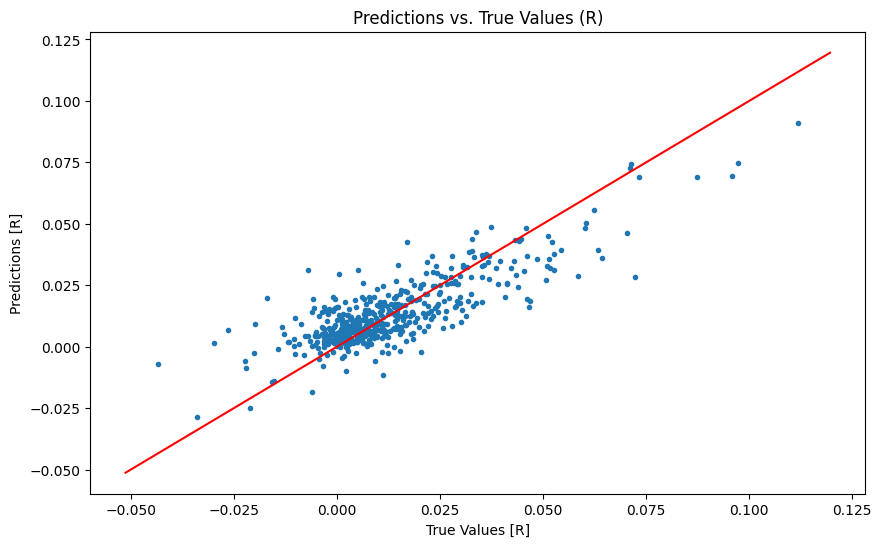

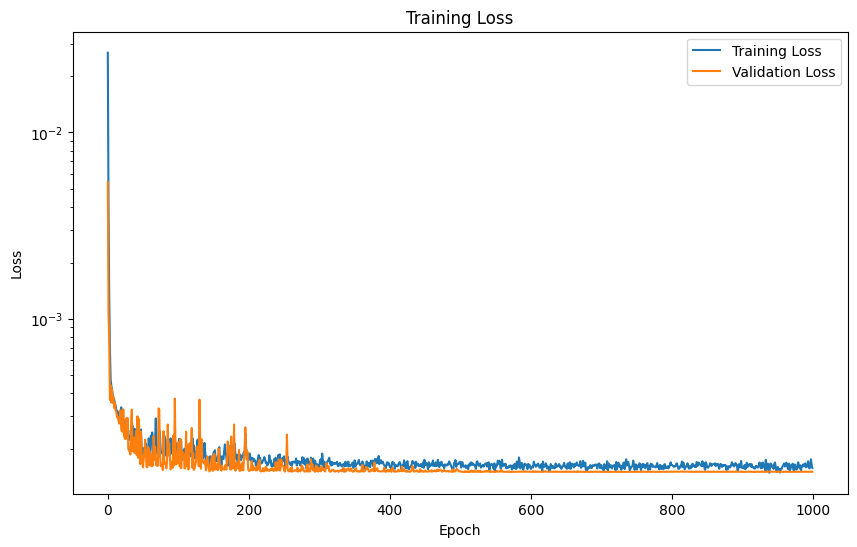

In [8]:
# Plot the predictions against the actual values
plt.figure(figsize=(10, 6))
plt.plot(pd.DataFrame(y_test).iloc[:,0], predictions, '.')
# plt.plot(y_test_2d, predictions, '.')
plt.xlabel('True Values [R]')
plt.ylabel('Predictions [R]')
plt.title('Predictions vs. True Values (R)')
# Make a 45 degree line in the same scale and range
x = np.linspace(*plt.gca().get_xlim())
plt.plot(x, x,'-', color='red')

# Plot the loss vs. epochs
plt.figure(figsize=(10, 6))
plt.semilogy(history.history['loss'], label='Training Loss')
plt.semilogy(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss')
plt.show()

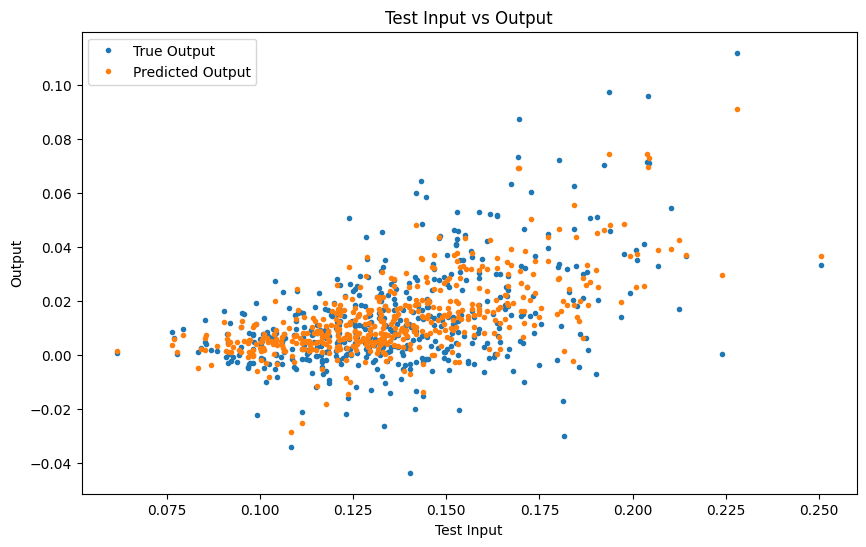

In [9]:
plt.figure(figsize=(10, 6))
#Plot the true output and the predicted output
plt.plot(pd.DataFrame(X_test).iloc[:,0], pd.DataFrame(y_test).iloc[:,0],'.', label='True Output')
plt.plot(pd.DataFrame(X_test).iloc[:,0], predictions,'.', label='Predicted Output')
# plt.plot(x_test_2d[:,0], y_test_2d,'.', label='True Output')
# plt.plot(x_test_2d[:,0], predictions,'.', label='Predicted Output')

plt.xlabel('Test Input')
plt.ylabel('Output')
plt.title('Test Input vs Output')
plt.legend()
plt.show()

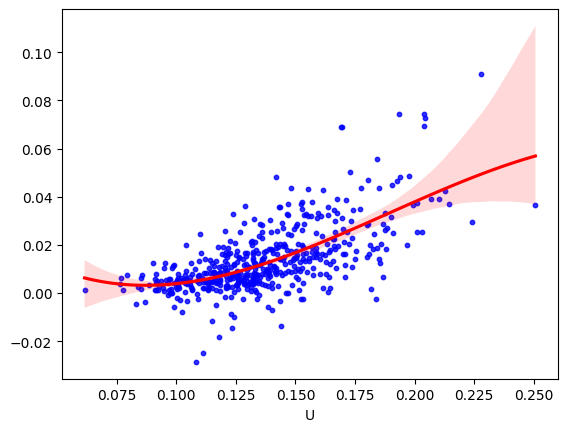

In [16]:
import seaborn as sns

# Plot the scatter plot with a regression line
sns.regplot(x=pd.DataFrame(X_test).iloc[:,0], y=predictions, scatter_kws={"color": "blue", 's': 10}, line_kws={"color": "red"}, order=3)

plt.show()

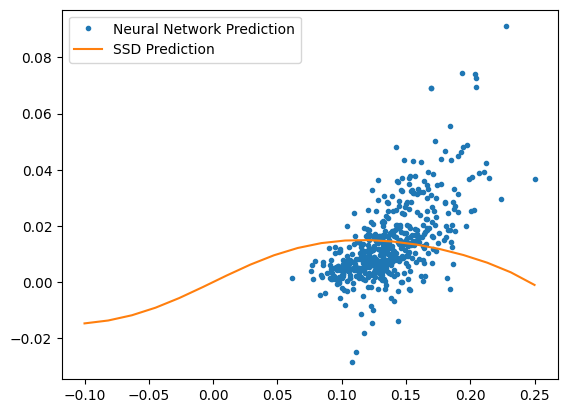

In [14]:
with open("./variables.pickle", "rb") as f:
    R_space, U_space = pickle.load(f)
    
# plt.plot(test_input[sorted_indices], predictions[sorted_indices], label='Neural Network Prediction')
plt.plot(pd.DataFrame(X_test).iloc[:,0], predictions,'.', label='Neural Network Prediction')
plt.plot(U_space, R_space, label='SSD Prediction')
#plt.ylim(0, 0.02)
plt.legend()
plt.show()

# SINE FUNCTION

In [163]:
data = pd.read_csv('./sinx_train_features.csv')
y = data['y']
X = data.drop(['y'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=True, random_state=42)

In [164]:
X_test.shape

(19992, 19)

In [171]:
model = keras.Sequential([
    keras.layers.Dense(19, activation='tanh', input_shape=(19,), kernel_initializer='glorot_normal'),
    keras.layers.Dense(8, activation='tanh', kernel_initializer='glorot_normal'),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(8, activation='tanh', kernel_initializer='glorot_normal'),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(1)
])

# Create the optimizer
optimizer = keras.optimizers.Adam(learning_rate = 0.01)

# Compile the model
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Train the model
epochs = 30  # Number of training iterations
batch_size = 64 # Number of samples per gradient update

# Create a learning rate scheduler
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-8)

# Add the scheduler to the callbacks list
callbacks = [lr_scheduler]

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=callbacks, validation_split=0.1)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print("Test loss:", loss)

# Make predictions using the trained model
predictions = model.predict(X_test)

Epoch 1/30
422/422 [==============================] - 2s 2ms/step - loss: 0.0213 - mae: 0.1080 - val_loss: 0.0105 - val_mae: 0.0906 - lr: 0.0100
Epoch 2/30
422/422 [==============================] - 1s 2ms/step - loss: 0.0113 - mae: 0.0932 - val_loss: 0.0104 - val_mae: 0.0904 - lr: 0.0100
Epoch 3/30
422/422 [==============================] - 1s 2ms/step - loss: 0.0111 - mae: 0.0924 - val_loss: 0.0105 - val_mae: 0.0909 - lr: 0.0100
Epoch 4/30
422/422 [==============================] - 1s 2ms/step - loss: 0.0108 - mae: 0.0918 - val_loss: 0.0104 - val_mae: 0.0904 - lr: 0.0100
Epoch 5/30
422/422 [==============================] - 1s 2ms/step - loss: 0.0107 - mae: 0.0917 - val_loss: 0.0104 - val_mae: 0.0905 - lr: 0.0100
Epoch 6/30
422/422 [==============================] - 1s 2ms/step - loss: 0.0107 - mae: 0.0917 - val_loss: 0.0104 - val_mae: 0.0904 - lr: 0.0100
Epoch 7/30
422/422 [==============================] - 1s 2ms/step - loss: 0.0107 - mae: 0.0916 - val_loss: 0.0104 - val_mae: 0.090

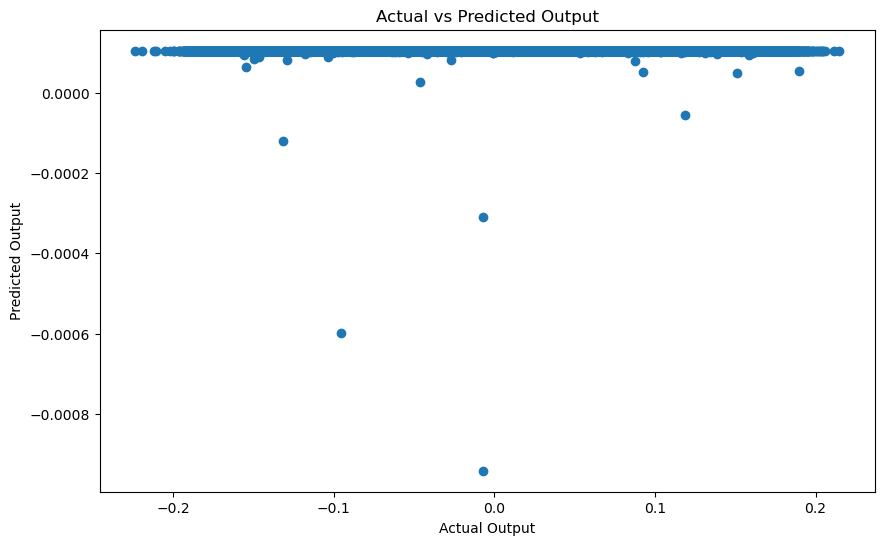

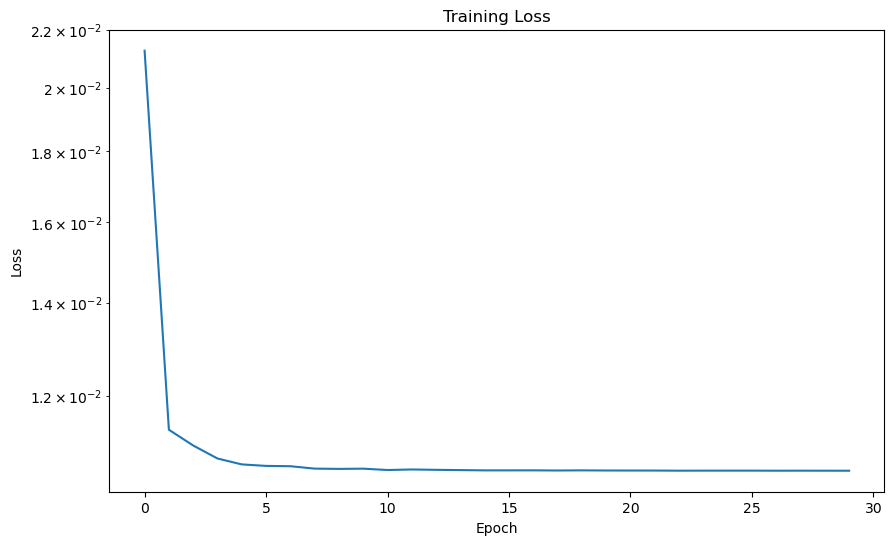

In [172]:
# Plotting the results

plt.figure(figsize=(10, 6))
plt.scatter(pd.DataFrame(y_test).iloc[:,0], predictions)
plt.xlabel('Actual Output')
plt.ylabel('Predicted Output')
plt.title('Actual vs Predicted Output')
plt.show()

plt.figure(figsize=(10, 6))
plt.semilogy(history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

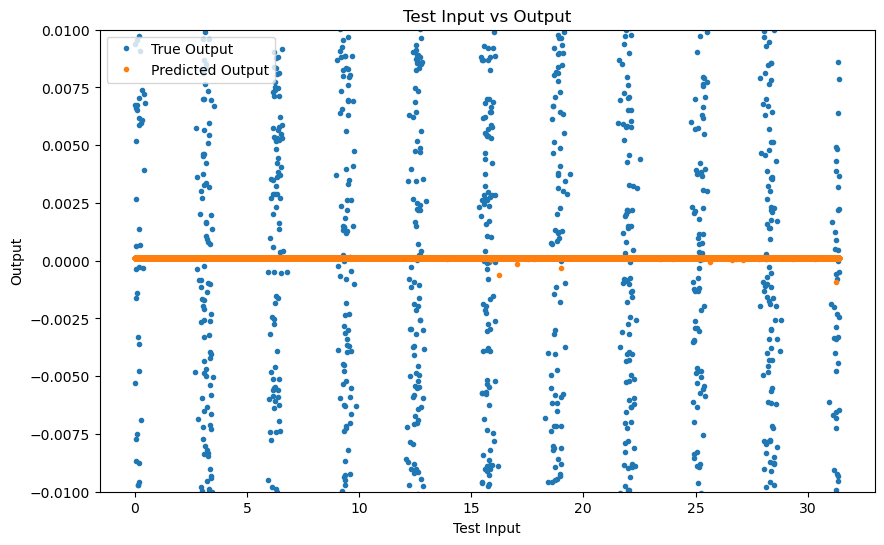

In [173]:
plt.figure(figsize=(10, 6))
#Plot the true output and the predicted output
plt.plot(pd.DataFrame(X_test).iloc[:,0], pd.DataFrame(y_test).iloc[:,0],'.', label='True Output')
plt.plot(pd.DataFrame(X_test).iloc[:,0], predictions,'.', label='Predicted Output')
plt.xlabel('Test Input')
plt.ylabel('Output')
plt.title('Test Input vs Output')
plt.ylim(-0.01,0.01)
plt.legend()
plt.show()